In [2]:
# Importing libraries for data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

# Importing libraries for text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from textblob import TextBlob
ps = PorterStemmer()

# Importing libraries for feature extraction and preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

# Importing libraries for handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# Importing libraries for model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Importing libraries for calculating similarity and distances
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

In [3]:
df = pd.read_csv("all-data.csv", encoding='latin1')
df.head()

,Sentiment,News_statement
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
df.shape

(4846, 2)

### DROPPING DUPLICATES

In [5]:
df.duplicated().sum()

6

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### BASIC INFORMATION ABOUT DATA / DATA PREPROCESSING 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Sentiment       4840 non-null   object
 1   News_statement  4840 non-null   object
dtypes: object(2)
memory usage: 113.4+ KB


In [8]:
df.isna().sum()

Sentiment         0
News_statement    0
dtype: int64

In [9]:
df['Sentiment'].value_counts()

neutral     2873
positive    1363
negative     604
Name: Sentiment, dtype: int64

The data is imbalanced with a higher number of neutral instances compared to positive and negative ones. We will take care of this.

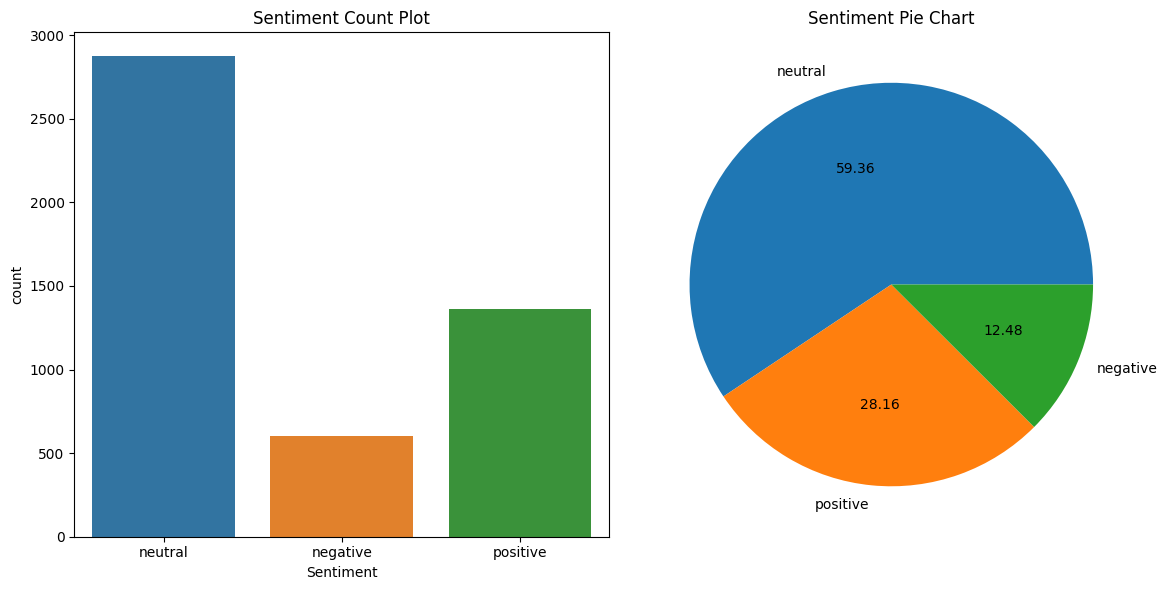

In [10]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the count plot on the first subplot
sns.countplot(x=df['Sentiment'], ax=ax[0])
ax[0].set_title('Sentiment Count Plot')

# Plot the pie chart on the second subplot
sentiment_counts = df['Sentiment'].value_counts()
ax[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct="%0.2f")
ax[1].set_title('Sentiment Pie Chart')

# Show the plots
plt.tight_layout()
plt.show()

- The dataset has more instances of neutral sentiment than positive or negative sentiments, with positive instances outnumbering negative ones. This distribution could impact the analysis and modeling steps, particularly in terms of handling class imbalance, which might necessitate techniques like resampling or adjusting class weights during model training.

### ENCODING OF TARGET VARIABLE

In [11]:
# Define the mapping for grouping
group_mapping = {'neutral': 0, 'positive': 1, 'negative': -1}

# Apply the mapping
df['Sentiment'] = df['Sentiment'].map(group_mapping)
df.head()

,Sentiment,News_statement
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,-1,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


In [11]:
# # Initialize the LabelEncoder
# label_encoder = LabelEncoder()

# # Fit and transform the Sentiment column
# df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
# df

## EDA

#### (A) NUMBER OF CHARACTERS

In [12]:
df['num_characters'] = df['News_statement'].apply(len)
df.head()

,Sentiment,News_statement,num_characters
0,0,"According to Gran , the company has no plans t...",127
1,0,Technopolis plans to develop in stages an area...,190
2,-1,The international electronic industry company ...,228
3,1,With the new production plant the company woul...,206
4,1,According to the company 's updated strategy f...,203


<Axes: xlabel='num_characters', ylabel='Count'>

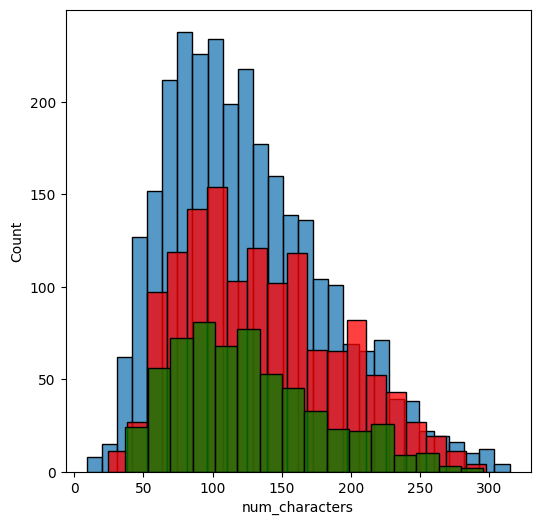

In [13]:
plt.figure(figsize=(6,6))
sns.histplot(df[df['Sentiment'] == 0]['num_characters'])
sns.histplot(df[df['Sentiment'] == 1]['num_characters'],color='red')
sns.histplot(df[df['Sentiment'] == -1]['num_characters'],color='green')

- The majority of texts are concentrated between 50 to 150 characters. Neutral texts (blue) are the most frequent, followed by positive texts (red), and then negative texts (green). As the number of characters increases, the frequency of texts decreases for all sentiments.










#### (B) NUMBER OF WORDS

In [14]:
df['num_words'] = df['News_statement'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,Sentiment,News_statement,num_characters,num_words
0,0,"According to Gran , the company has no plans t...",127,25
1,0,Technopolis plans to develop in stages an area...,190,31
2,-1,The international electronic industry company ...,228,36
3,1,With the new production plant the company woul...,206,33
4,1,According to the company 's updated strategy f...,203,41


<Axes: xlabel='num_words', ylabel='Count'>

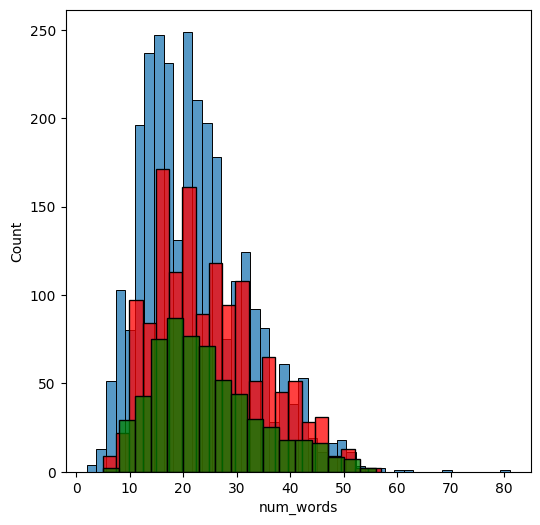

In [15]:
plt.figure(figsize=(6,6))
sns.histplot(df[df['Sentiment'] == 0]['num_words'])
sns.histplot(df[df['Sentiment'] == 1]['num_words'],color='red')
sns.histplot(df[df['Sentiment'] == -1]['num_words'],color='green')

#### (C) NUMBER OF SENTENCES

In [16]:
df['num_sentences'] = df['News_statement'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,Sentiment,News_statement,num_characters,num_words,num_sentences
0,0,"According to Gran , the company has no plans t...",127,25,1
1,0,Technopolis plans to develop in stages an area...,190,31,1
2,-1,The international electronic industry company ...,228,36,1
3,1,With the new production plant the company woul...,206,33,1
4,1,According to the company 's updated strategy f...,203,41,1


In [17]:
df['num_sentences'].value_counts()

1    4786
2      51
3       3
Name: num_sentences, dtype: int64

### Description

In [18]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4840.000000,4840.000000,4840.000000
mean,128.076446,23.139669,1.011777
std,56.416479,9.987071,0.113492
min,9.000000,2.000000,1.000000
25%,84.000000,16.000000,1.000000
50%,119.000000,21.000000,1.000000
75%,163.000000,29.000000,1.000000
max,315.000000,81.000000,3.000000


The dataset consists of 4,840 text samples. On average, each text contains approximately 128 characters, 23 words, and 1 sentence. The variability is moderate, with a standard deviation of about 56 characters and 10 words, while the number of sentences has low variability. The shortest text has 9 characters, 2 words, and 1 sentence, whereas the longest text reaches 315 characters, 81 words, and 3 sentences. The interquartile range indicates that 50% of the texts fall between 84 and 163 characters and 16 to 29 words, with most texts being single sentences.

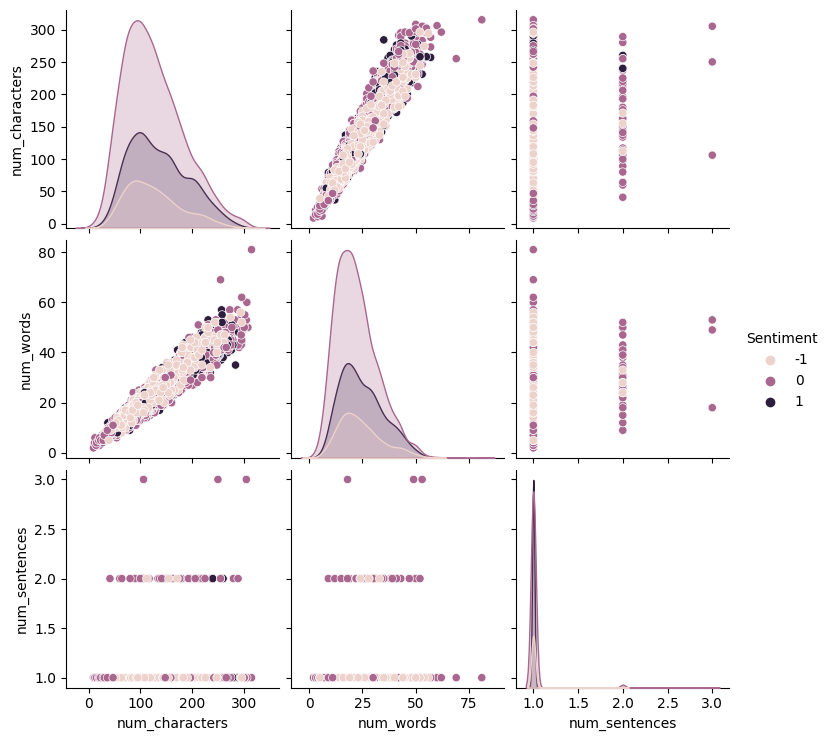

In [19]:
sns.pairplot(df,hue='Sentiment')

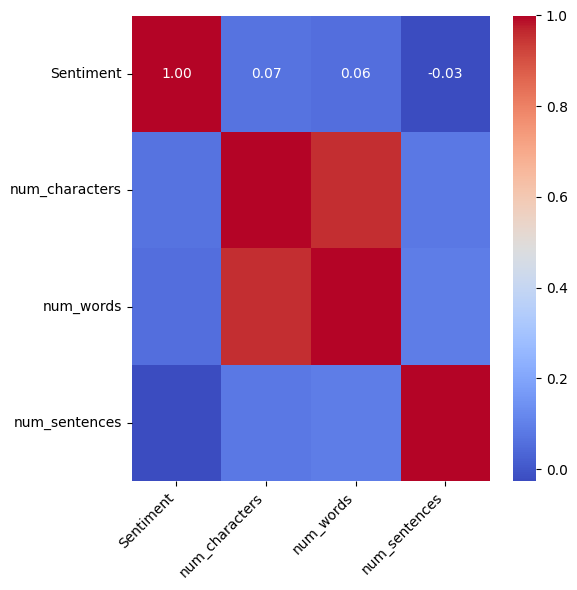

In [20]:
# Set the figure size to make the heatmap more readable
plt.figure(figsize=(6, 6))

# Plot the heatmap with correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})

# Adjust the heatmap to ensure labels don't overlap
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the heatmap
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

# Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [12]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [13]:
df['News_statement'] = df['News_statement'].apply(transform_text)

# Display the processed text
print(df['News_statement'])

0       accord gran compani plan move product russia a...
1       technopoli plan develop stage area less squar ...
2       intern electron industri compani elcoteq laid ...
3       new product plant compani would increas capac ...
4       accord compani updat strategi year baswar targ...
                              ...                        
4841    london marketwatch share price end lower londo...
4842    rinkuskiai beer sale fell per cent million lit...
4843    oper profit fell eur mn eur mn 2007 includ ves...
4844    net sale paper segment decreas eur mn second q...
4845    sale finland decreas januari sale outsid finla...
Name: News_statement, Length: 4840, dtype: object


# TEXT POLARITY

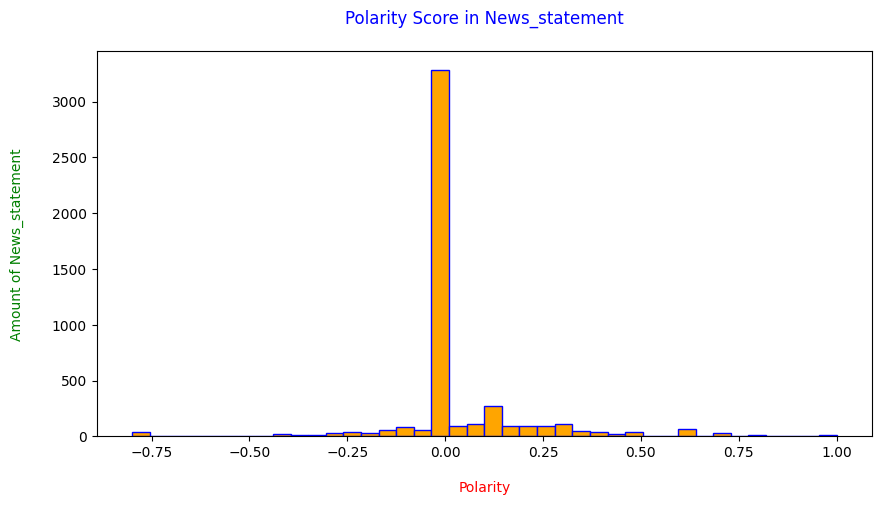

In [23]:
df["polarity"] = df["News_statement"].map(lambda Text: TextBlob(Text).sentiment.polarity)

df["polarity"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Polarity Score in News_statement", color = "blue", pad = 20)
plt.xlabel("Polarity", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show()

The histogram presents the distribution of polarity scores in news statements, indicating the sentiment associated with each statement. Here's a summary:

- **Neutral Dominance**: The vast majority of news statements have a polarity score around 0, reflecting a neutral sentiment.
- **Skewed Distribution**: There are fewer statements with positive (greater than 0) or negative (less than 0) polarity scores, highlighting a significant imbalance in sentiment distribution.
- **Low Extremes**: Very few statements exhibit extreme positive or negative sentiments, as shown by the low frequencies at the ends of the polarity scale.
- **Implications for Analysis**: The pronounced peak at the neutral score suggests that special attention is needed to address this imbalance for effective sentiment analysis and model training.

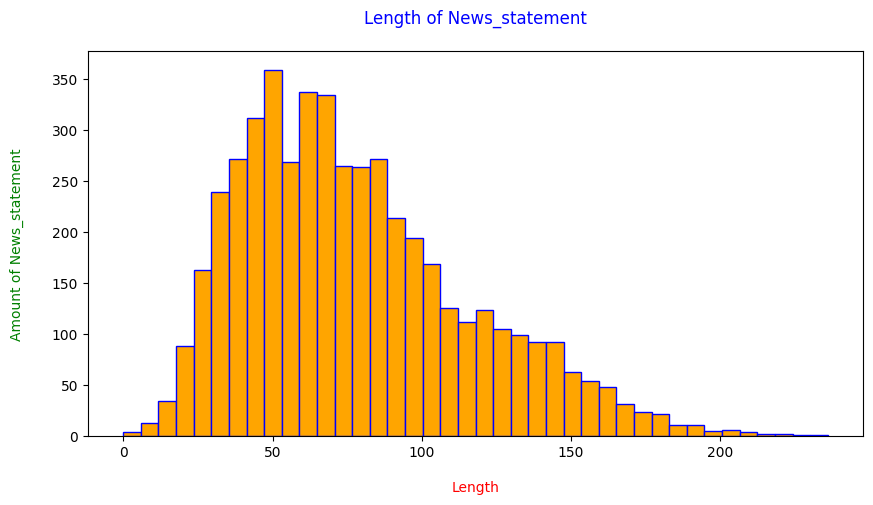

In [24]:
df["length"] = df["News_statement"].astype(str).apply(len)
df["length"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Length of News_statement", color = "blue", pad = 20)
plt.xlabel("Length", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show()

The histogram shows the distribution of the lengths of news statements. Here’s a summary interpretation:

- **Length Distribution**: The lengths of news statements vary, with most statements falling between 20 and 100 characters.
- **Peak Range**: The highest frequency of news statements is around 50-60 characters in length.
- **Skewness**: The distribution is right-skewed, with a longer tail extending towards the higher lengths, indicating fewer statements with lengths greater than 100 characters.
- **Maximum Length**: Very few news statements exceed 150 characters, and almost none go beyond 200 characters.
- **Implications**: This distribution can help in preprocessing steps like padding or truncating sequences to a standard length for model training and can inform the selection of appropriate sequence lengths for NLP tasks.

# Word Counts

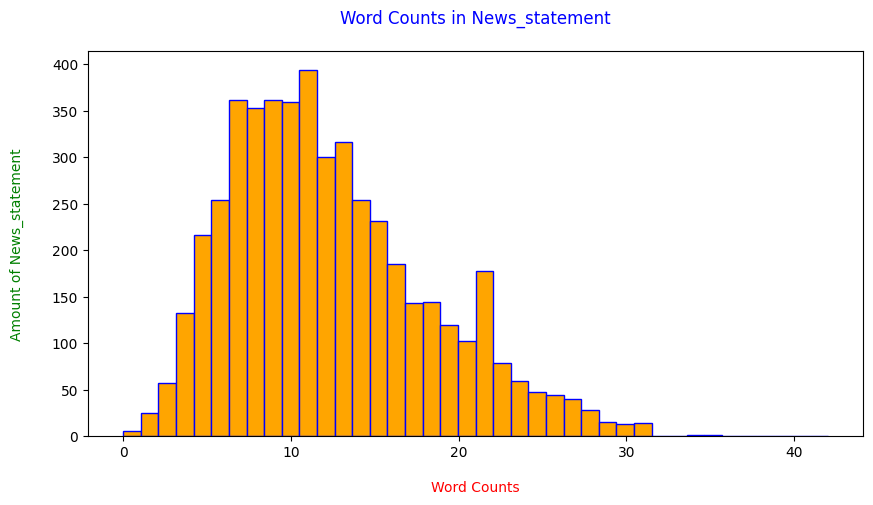

In [25]:
df["word_counts"] = df["News_statement"].apply(lambda x: len(str(x).split()))
df["word_counts"].plot(kind = "hist", bins = 40, edgecolor = "blue", linewidth = 1, color = "orange", figsize = (10,5))
plt.title("Word Counts in News_statement", color = "blue", pad = 20)
plt.xlabel("Word Counts", labelpad = 15, color = "red")
plt.ylabel("Amount of News_statement", labelpad = 20, color = "green")

plt.show() 

# N-Gram Analysis

N-Gram Function

In [26]:
def Gram_Analysis(Corpus, Gram, N):
  # Vectorizer
  Vectorizer = CountVectorizer(stop_words = list(Stopwords), ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key = lambda x:x[1], reverse = True)

  return words[:N]

##### Filter The DataFrame Based On Sentiments

In [27]:
# Use dropna() so the base DataFrame is not affected
Positive = df[df["Sentiment"] == 1]
Neutral = df[df["Sentiment"] == 0]
Negative = df[df["Sentiment"] == -1]

##### Unigram of Reviews Based on Sentiments

Text(0, 0.5, 'Top Words')

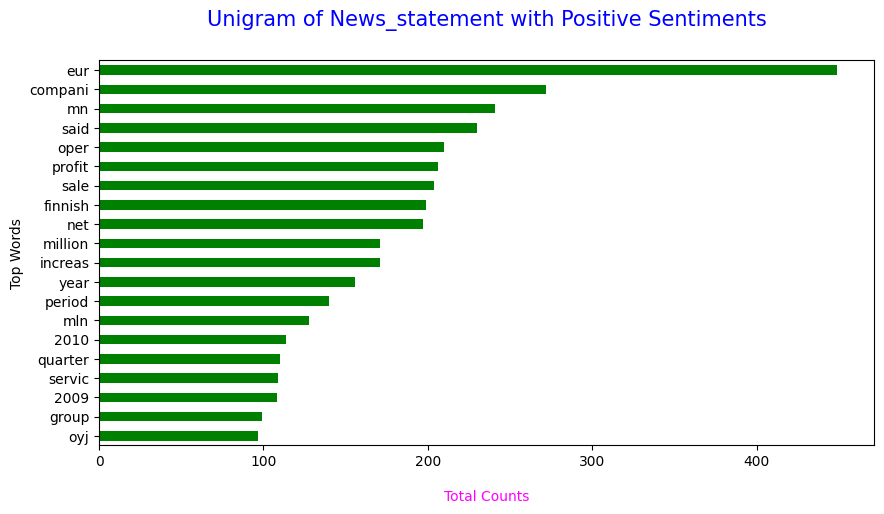

In [28]:
 #Stopwords
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])


def Gram_Analysis(Corpus, Gram, N):
    # Initialize CountVectorizer with list of stopwords
    Vectorizer = CountVectorizer(stop_words=list(Stopwords), ngram_range=(Gram, Gram))
    
    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)
    
    # Check if vocabulary is empty
    if not Vectorizer.vocabulary_:
        raise ValueError("Empty vocabulary after removing stop words.")
    
    # N-Grams Frequency
    Count = ngrams.sum(axis=0)
    Frequency = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]
    
    # Sorting Frequency
    Frequency = sorted(Frequency, key=lambda x: x[1], reverse=True)
    
    return Frequency[:N]


#Positive = df[df["Sentiment"] == 1]
# Finding Unigram
words = Gram_Analysis(Positive["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Positive Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")

Text(0, 0.5, 'Top Words')

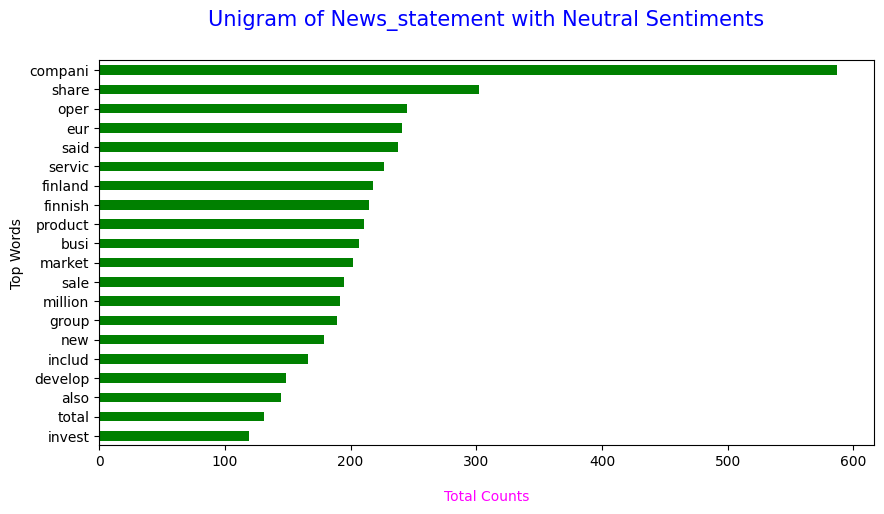

In [29]:
def Gram_Analysis(Corpus, Gram, N):
    # Initialize CountVectorizer with list of stopwords
    Vectorizer = CountVectorizer(stop_words=list(Stopwords), ngram_range=(Gram, Gram))
    
    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)
    
    # Check if vocabulary is empty
    if not Vectorizer.vocabulary_:
        raise ValueError("Empty vocabulary after removing stop words.")
    
    # N-Grams Frequency
    Count = ngrams.sum(axis=0)
    Frequency = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]
    
    # Sorting Frequency
    Frequency = sorted(Frequency, key=lambda x: x[1], reverse=True)
    
    return Frequency[:N]


#Positive = df[df["Sentiment"] == 1]
# Finding Unigram
words = Gram_Analysis(Neutral["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Neutral Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0, 0.5, 'Top Words')

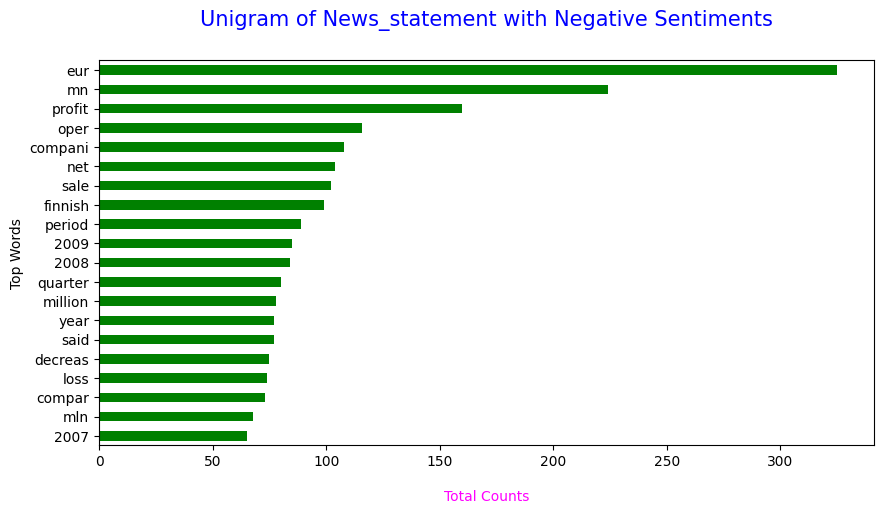

In [30]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you have the NLTK stopwords
nltk.download('stopwords')

# Custom stopwords set
#Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

def Gram_Analysis(Corpus, Gram, N):
    # Initialize CountVectorizer with list of stopwords
    Vectorizer = CountVectorizer(stop_words=list(Stopwords), ngram_range=(Gram, Gram))
    
    # N-Grams Matrix
    ngrams = Vectorizer.fit_transform(Corpus)
    
    # Check if vocabulary is empty
    if not Vectorizer.vocabulary_:
        raise ValueError("Empty vocabulary after removing stop words.")
    
    # N-Grams Frequency
    Count = ngrams.sum(axis=0)
    Frequency = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]
    
    # Sorting Frequency
    Frequency = sorted(Frequency, key=lambda x: x[1], reverse=True)
    
    return Frequency[:N]


# Finding Unigram
words = Gram_Analysis(Negative["News_statement"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green", figsize=(10, 5))
plt.title("Unigram of News_statement with Negative Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words")    

#### Bigram of Reviews Based On Sentiments

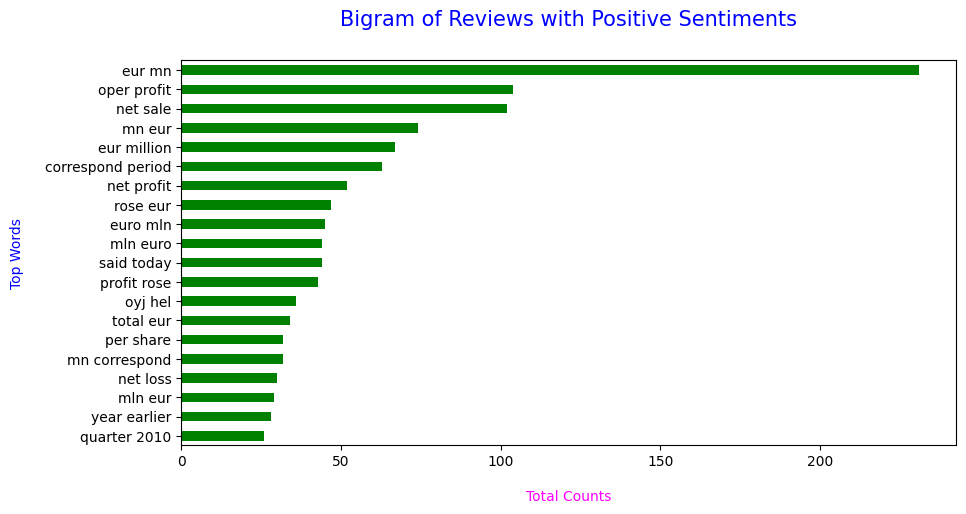

In [31]:
# Finding Bigram
words = Gram_Analysis(Positive["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Bigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

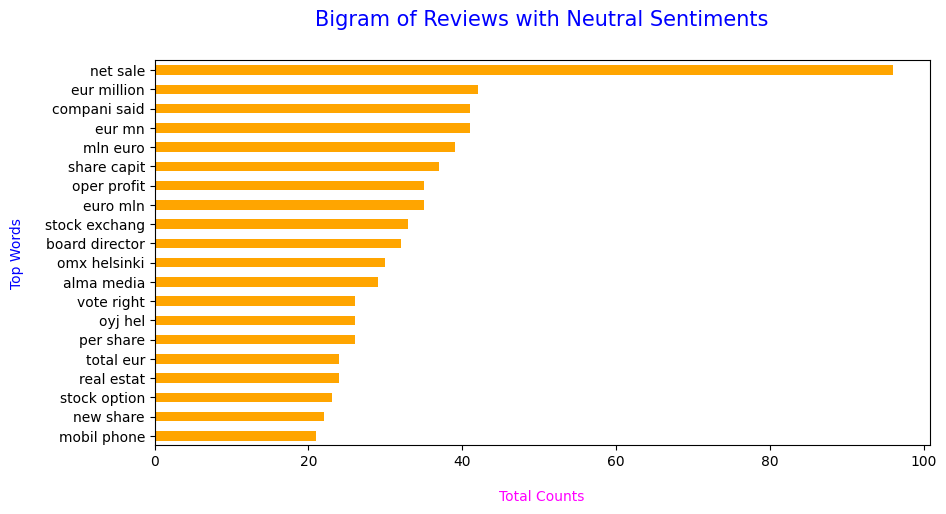

In [32]:
# Finding Bigram
words = Gram_Analysis(Neutral["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Bigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

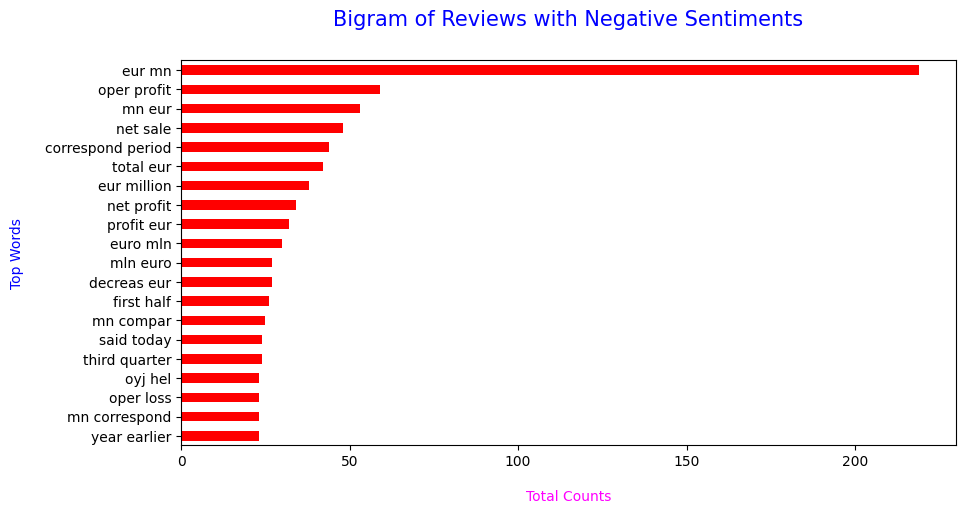

In [33]:
# Finding Bigram
words = Gram_Analysis(Negative["News_statement"], 2, 20)
Bigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Bigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

#### Trigram of Reviews Based On Sentiments

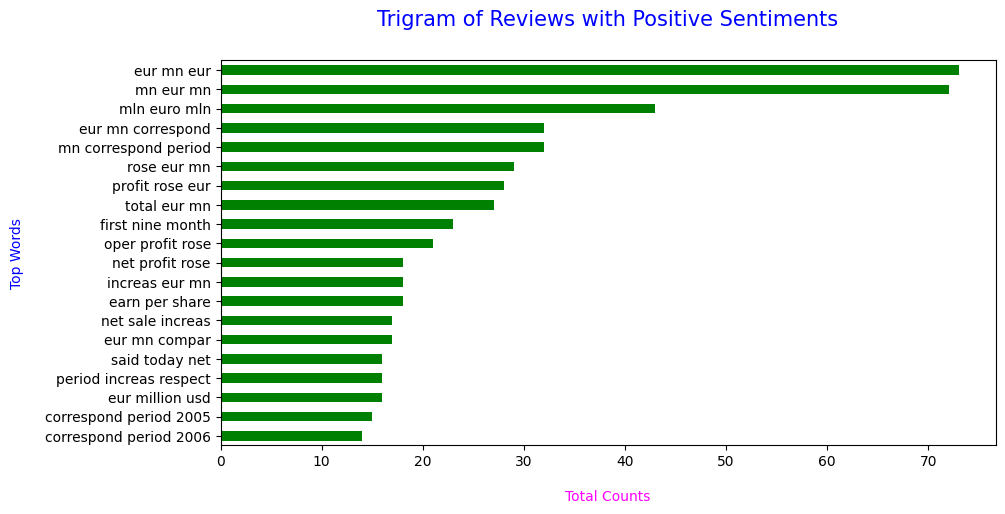

In [34]:
# Finding Trigram
words = Gram_Analysis(Positive["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "green", figsize = (10, 5))
plt.title("Trigram of Reviews with Positive Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

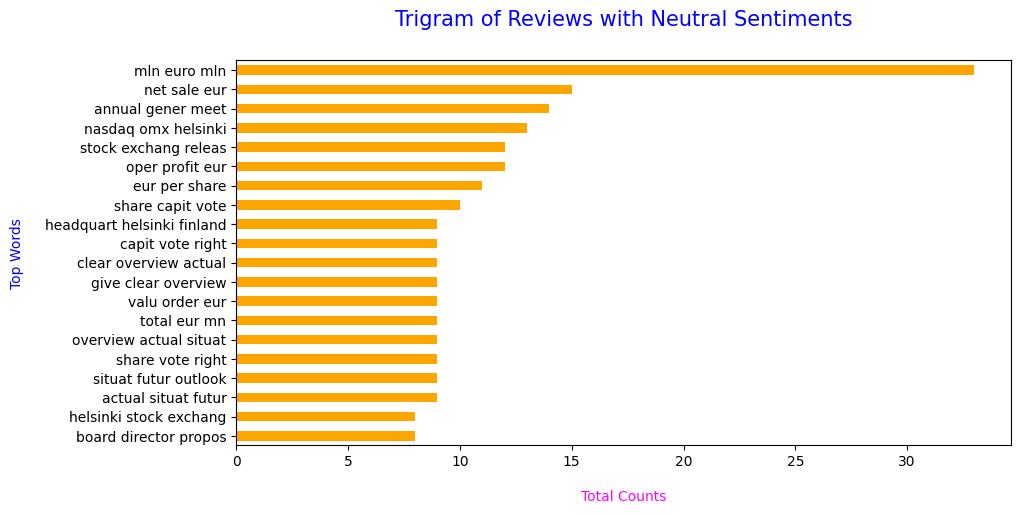

In [35]:
# Finding Trigram
words = Gram_Analysis(Neutral["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "orange", figsize = (10, 5))
plt.title("Trigram of Reviews with Neutral Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()

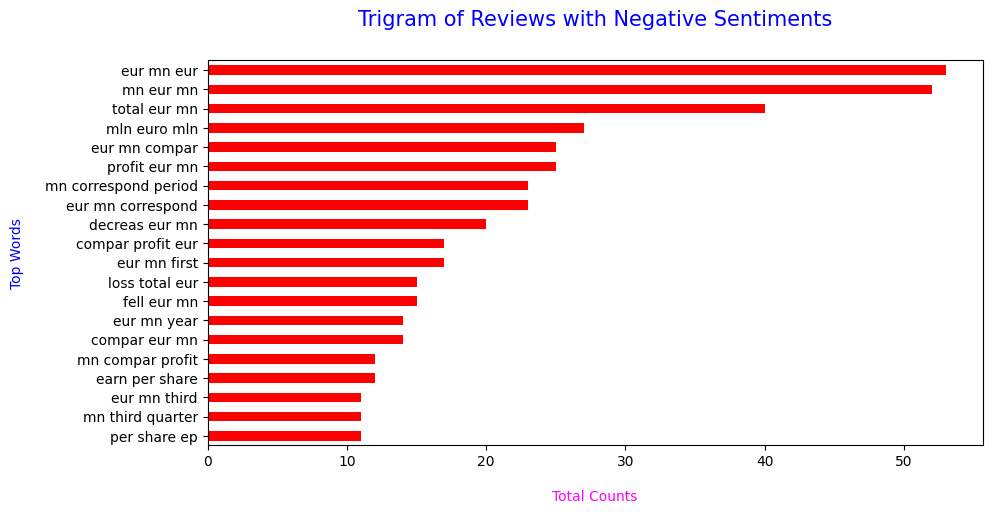

In [36]:
# Finding Trigram
words = Gram_Analysis(Negative["News_statement"], 3, 20)
Trigram = pd.DataFrame(words, columns = ["Words", "Counts"])

# Visualization
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind = "barh", color = "red", figsize = (10, 5))
plt.title("Trigram of Reviews with Negative Sentiments", loc = "center", fontsize = 15, color = "blue", pad = 25)
plt.xlabel("Total Counts", color = "magenta", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Top Words", color = "blue", fontsize = 10, labelpad = 15)
plt.show()
     

# Word Clouds

##### Word Cloud of Reviews with Positive Sentiments

In [37]:
# Assuming Positive["News_statement"] is a list or series of text data
text_data = str(Positive["News_statement"])

# Generate the word cloud
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=Stopwords).generate(text_data)

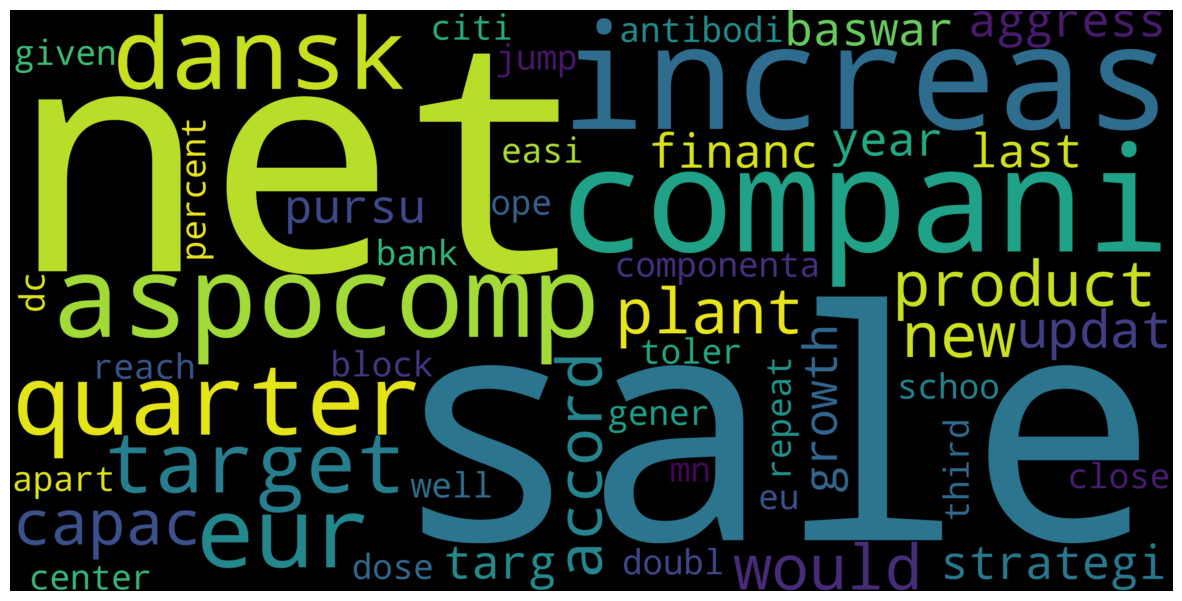

In [38]:
# wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Positive["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##### Word Cloud of Reviews with Neutral Sentiments

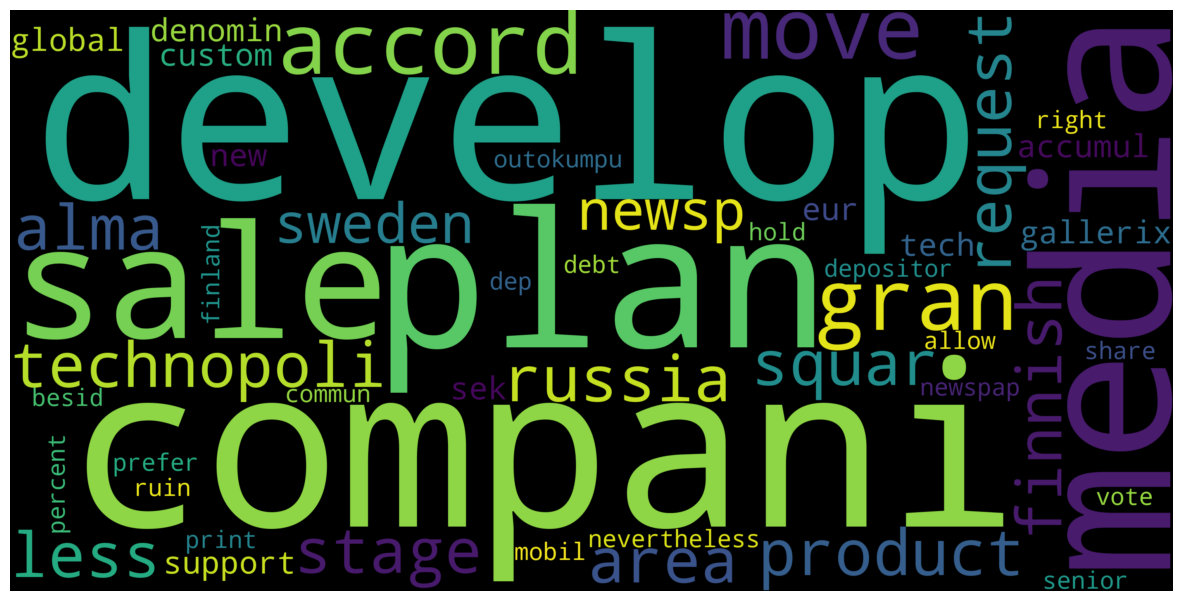

In [39]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Neutral["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

##### Word Cloud of Reviews with Negative Sentiments

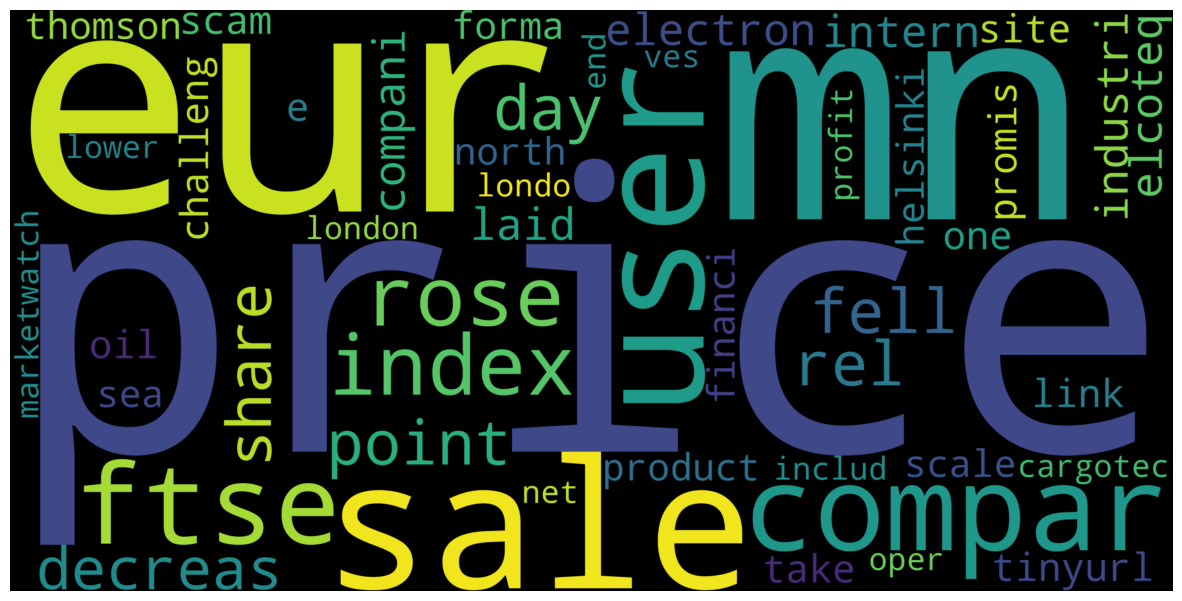

In [40]:
wordCloud = WordCloud(max_words = 50, width = 3000, height = 1500, stopwords = Stopwords).generate(str(Negative["News_statement"]))
plt.figure(figsize = (15, 15))
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# TOP WORDS

In [41]:
positive_corpus = []
for msg in df[df['Sentiment'] == 1]['News_statement'].tolist():
    for word in msg.split():
        positive_corpus.append(word)
        
negative_corpus = []
for msg in df[df['Sentiment'] == -1]['News_statement'].tolist():
    for word in msg.split():
        negative_corpus.append(word)
        
neutral_corpus = []
for msg in df[df['Sentiment'] == 0]['News_statement'].tolist():
    for word in msg.split():
        neutral_corpus.append(word)

In [42]:
print(len(positive_corpus))
print(len(negative_corpus))
print(len(neutral_corpus))

18082
7516
34089


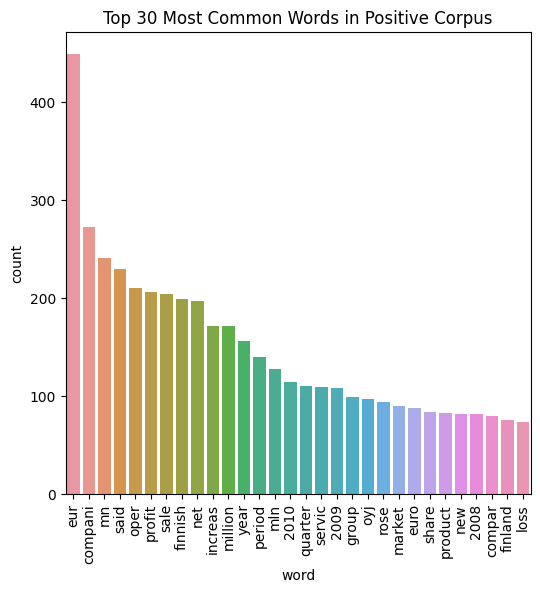

In [43]:
# Count the frequency of each word
word_counts = Counter(positive_corpus)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Convert the most common words to a DataFrame
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Create a barplot using seaborn
plt.figure(figsize=(6, 6))
sns.barplot(x='word', y='count', data=df_most_common)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in Positive Corpus')
plt.show()

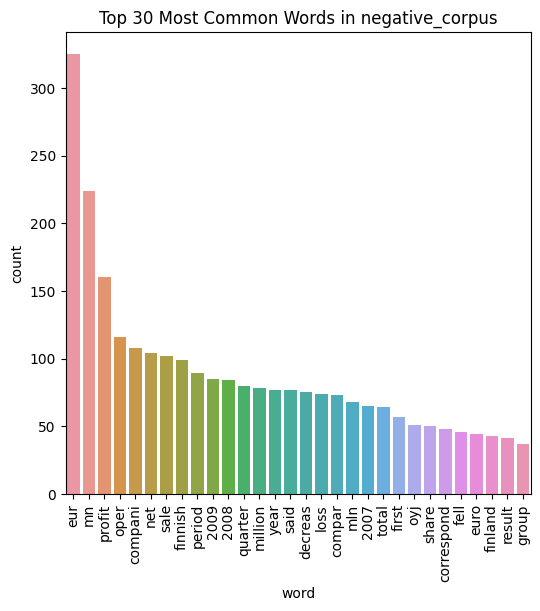

In [44]:
# Count the frequency of each word
word_counts = Counter(negative_corpus)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Convert the most common words to a DataFrame
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Create a barplot using seaborn
plt.figure(figsize=(6, 6))
sns.barplot(x='word', y='count', data=df_most_common)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in negative_corpus')
plt.show()

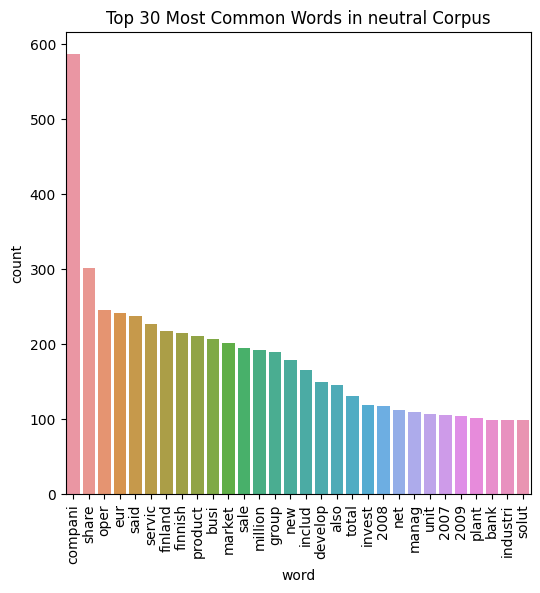

In [45]:
# Count the frequency of each word
word_counts = Counter(neutral_corpus)

# Get the 30 most common words
most_common_words = word_counts.most_common(30)

# Convert the most common words to a DataFrame
df_most_common = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Create a barplot using seaborn
plt.figure(figsize=(6, 6))
sns.barplot(x='word', y='count', data=df_most_common)
plt.xticks(rotation='vertical')
plt.title('Top 30 Most Common Words in neutral Corpus')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# SPLITTING OF THE DATA

In [14]:
# Split data
X = df['News_statement']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# BAG OF WORDS (BOW)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# BOW
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

## Step 1 : Smote

In [16]:
from imblearn.over_sampling import SMOTE
Balancer = SMOTE(random_state = 42)
X_train_bow, y_train_bow = Balancer.fit_resample(X_train_bow, y_train)

In [17]:
# Check shapes
print(f"Shape of X_train_bow: {X_train_bow.shape}")
print(f"Shape of X_test_bow: {X_test_bow.shape}")
print(f"Shape of y_train_bow : {y_train_bow.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(Counter(y_train))
Counter(y_train_bow)

Shape of X_train_bow: (6930, 6402)
Shape of X_test_bow: (968, 6402)
Shape of y_train_bow : (6930,)
Shape of y_test: (968,)
Counter({0: 2310, 1: 1076, -1: 486})


Counter({-1: 2310, 0: 2310, 1: 2310})

## Step 2: Similarity Score

(a) Cosine Similarity 
(b) Manhattan Similarity
(c) Euclidean Similarity

In [18]:
# Calculate Cosine Similarity Matrix
cosine_sim_train = cosine_similarity(X_train_bow)
print("Cosine Similarity Matrix:")
print(cosine_sim_train)

# Calculate Manhattan Distance Matrix
manhattan_dist_train = manhattan_distances(X_train_bow)
print("\nManhattan Distance Matrix:")
print(manhattan_dist_train)

# Calculate Euclidean Distance Matrix
euclidean_dist_train = euclidean_distances(X_train_bow)
print("\nEuclidean Distance Matrix:")
print(euclidean_dist_train)

Cosine Similarity Matrix:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Manhattan Distance Matrix:
[[ 0. 20. 22. ... 13. 15. 11.]
 [20.  0. 20. ... 11. 13.  9.]
 [22. 20.  0. ... 13. 15. 11.]
 ...
 [13. 11. 13. ...  0.  6.  2.]
 [15. 13. 15. ...  6.  0.  4.]
 [11.  9. 11. ...  2.  4.  0.]]

Euclidean Distance Matrix:
[[0.         5.09901951 5.65685425 ... 4.35889894 4.58257569 4.12310563]
 [5.09901951 0.         4.89897949 ... 3.31662479 3.60555128 3.        ]
 [5.65685425 4.89897949 0.         ... 4.12310563 4.35889894 3.87298335]
 ...
 [4.35889894 3.31662479 4.12310563 ... 0.         2.44948974 1.41421356]
 [4.58257569 3.60555128 4.35889894 ... 2.44948974 0.         2.        ]
 [4.12310563 3.         3.87298335 ... 1.41421356 2.         0.        ]]


In [19]:
cosine_sim_test = cosine_similarity(X_test_bow, X_train_bow)
manhattan_dist_test = manhattan_distances(X_test_bow, X_train_bow)
euclidean_dist_test = euclidean_distances(X_test_bow, X_train_bow)

## Step 3 : Modelling

#### (A) WITH COSINE

In [18]:
# Function to train and evaluate classifiers
def train_and_evaluate(clf, cosine_sim_train, y_train, cosine_sim_test, y_test, model_name):
    clf.fit(cosine_sim_train, y_train)
    y_pred = clf.predict(cosine_sim_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [19]:
# List to store results
results_cosine_bow = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "Logistic Regression")
results_cosine_bow.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.7118, F1 Score: 0.7112


In [21]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "SVC")
results_cosine_bow.append(('SVC', accuracy, f1))

Model: SVC, Accuracy: 0.6364, F1 Score: 0.6248


In [20]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "Random Forest")
results_cosine_bow.append(('Random Forest', accuracy, f1))

Model: Random Forest, Accuracy: 0.7025, F1 Score: 0.6744


In [25]:
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier(random_state=42)
accuracy, f1 = train_and_evaluate(clf_gb, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "Gradient Boosting")
results_cosine_bow.append(('Gradient Boosting', accuracy, f1))

Model: Gradient Boosting, Accuracy: 0.6746, F1 Score: 0.6647


In [22]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "Decision Tree")
results_cosine_bow.append(('Decision Tree', accuracy, f1))

Model: Decision Tree, Accuracy: 0.5764, F1 Score: 0.5782


In [23]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, cosine_sim_train, y_train_bow, cosine_sim_test, y_test, "Naive Bayes")
results_cosine_bow.append(('Naive Bayes', accuracy, f1))

Model: Naive Bayes, Accuracy: 0.6188, F1 Score: 0.5730


In [26]:
results_cosine_bow

[('Logistic Regression', 0.7117768595041323, 0.7112496259641312),
 ('Random Forest', 0.7024793388429752, 0.674445782036398),
 ('SVC', 0.6363636363636364, 0.6247914134933414),
 ('Decision Tree', 0.5764462809917356, 0.578231760495104),
 ('Naive Bayes', 0.618801652892562, 0.5729843846304855),
 ('Gradient Boosting', 0.6745867768595041, 0.6647447086898489)]

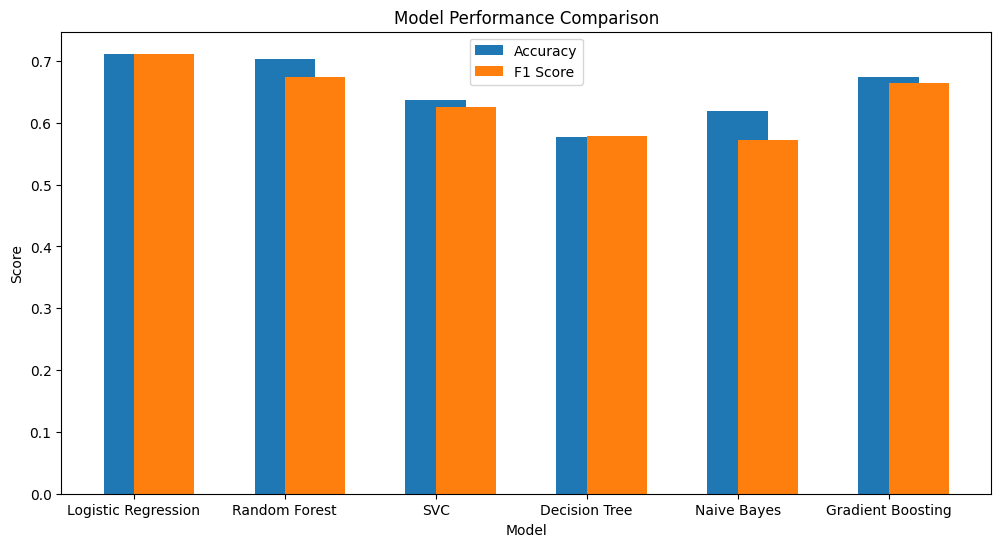

In [28]:
# Plotting results
model_names = [r[0] for r in results_cosine_bow]
accuracies = [r[1] for r in results_cosine_bow]
f1_scores = [r[2] for r in results_cosine_bow]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [29]:
df_results_cosine = pd.DataFrame(results_cosine_bow, columns=['Model', 'Accuracy', 'F1 Score'])

df_results_cosine_sorted = df_results_cosine.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
df_results_cosine_sorted

,Model,Accuracy,F1 Score
0,Logistic Regression,0.711777,0.711250
1,Random Forest,0.702479,0.674446
5,Gradient Boosting,0.674587,0.664745
2,SVC,0.636364,0.624791
4,Naive Bayes,0.618802,0.572984
3,Decision Tree,0.576446,0.578232


#### (B) WITH MANHATTAN

In [20]:
# Function to train and evaluate classifiers
def train_and_evaluate(clf, dist_train, y_train, dist_test, y_test, model_name):
    clf.fit(dist_train, y_train)
    y_pred = clf.predict(dist_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [21]:
# List to store results for Manhattan distance
results_manhattan_bow = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "Logistic Regression")
results_manhattan_bow.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.6260, F1 Score: 0.6260


In [22]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "SVC")
results_manhattan_bow.append(('SVC', accuracy, f1))

Model: SVC, Accuracy: 0.6043, F1 Score: 0.5431


In [23]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "Random Forest")
results_manhattan_bow.append(('Random Forest', accuracy, f1))


Model: Random Forest, Accuracy: 0.6560, F1 Score: 0.6207


In [24]:
# # Gradient Boosting Classifier
# clf_gb = GradientBoostingClassifier(random_state=42)
# accuracy, f1 = train_and_evaluate(clf_gb, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "Gradient Boosting")
# results_manhattan_bow.append(('Gradient Boosting', accuracy, f1))

In [25]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "Decision Tree")
results_manhattan_bow.append(('Decision Tree', accuracy, f1))

Model: Decision Tree, Accuracy: 0.5455, F1 Score: 0.5486


In [26]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, manhattan_dist_train, y_train_bow, manhattan_dist_test, y_test, "Naive Bayes")
results_manhattan_bow.append(('Naive Bayes', accuracy, f1))

Model: Naive Bayes, Accuracy: 0.4019, F1 Score: 0.4075


In [27]:
results_manhattan_bow

[('Logistic Regression', 0.6260330578512396, 0.6260475755137863),
 ('SVC', 0.6043388429752066, 0.5430572354482048),
 ('Random Forest', 0.65599173553719, 0.6207072536709192),
 ('Decision Tree', 0.5454545454545454, 0.5485568585318137),
 ('Naive Bayes', 0.4018595041322314, 0.4075034807251361)]

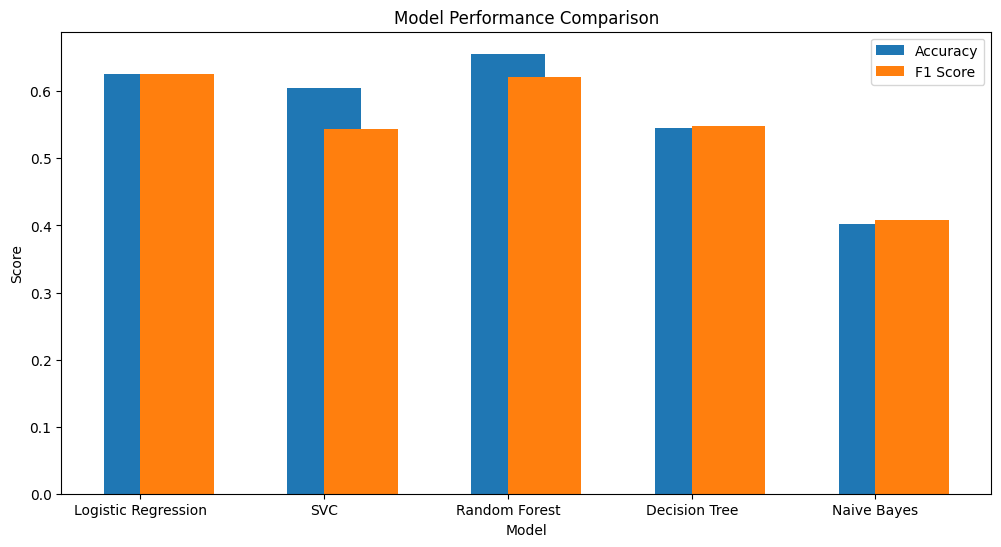

In [28]:
# Plotting results
model_names = [r[0] for r in results_manhattan_bow]
accuracies = [r[1] for r in results_manhattan_bow]
f1_scores = [r[2] for r in results_manhattan_bow]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [30]:
df_results_manhattan_bow = pd.DataFrame(results_manhattan_bow, columns=['Model', 'Accuracy', 'F1 Score'])

df_results_manhattan_sorted_bow = df_results_manhattan_bow.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
df_results_manhattan_sorted_bow

,Model,Accuracy,F1 Score
2,Random Forest,0.655992,0.620707
0,Logistic Regression,0.626033,0.626048
1,SVC,0.604339,0.543057
3,Decision Tree,0.545455,0.548557
4,Naive Bayes,0.401860,0.407503


#### (C) WITH EUCLIDEAN

In [31]:
# Function to train and evaluate classifiers
def train_and_evaluate(clf, dist_train, y_train, dist_test, y_test, model_name):
    clf.fit(dist_train, y_train)
    y_pred = clf.predict(dist_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [33]:
# List to store results for Euclidean distance
results_euclidean_bow = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "Logistic Regression")
results_euclidean_bow.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.6229, F1 Score: 0.5915


In [35]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "SVC")
results_euclidean_bow.append(('SVC', accuracy, f1))

Model: SVC, Accuracy: 0.5878, F1 Score: 0.5165


In [37]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "Random Forest")
results_euclidean_bow.append(('Random Forest', accuracy, f1))

Model: Random Forest, Accuracy: 0.6581, F1 Score: 0.6196


In [ ]:
# # Gradient Boosting Classifier
# clf_gb = GradientBoostingClassifier(random_state=42)
# accuracy, f1 = train_and_evaluate(clf_gb, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "Gradient Boosting")
# results_euclidean.append(('Gradient Boosting', accuracy, f1))

In [38]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "Decision Tree")
results_euclidean_bow.append(('Decision Tree', accuracy, f1))

Model: Decision Tree, Accuracy: 0.5671, F1 Score: 0.5676


In [39]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, euclidean_dist_train, y_train_bow, euclidean_dist_test, y_test, "Naive Bayes")
results_euclidean_bow.append(('Naive Bayes', accuracy, f1))

Model: Naive Bayes, Accuracy: 0.4421, F1 Score: 0.4177


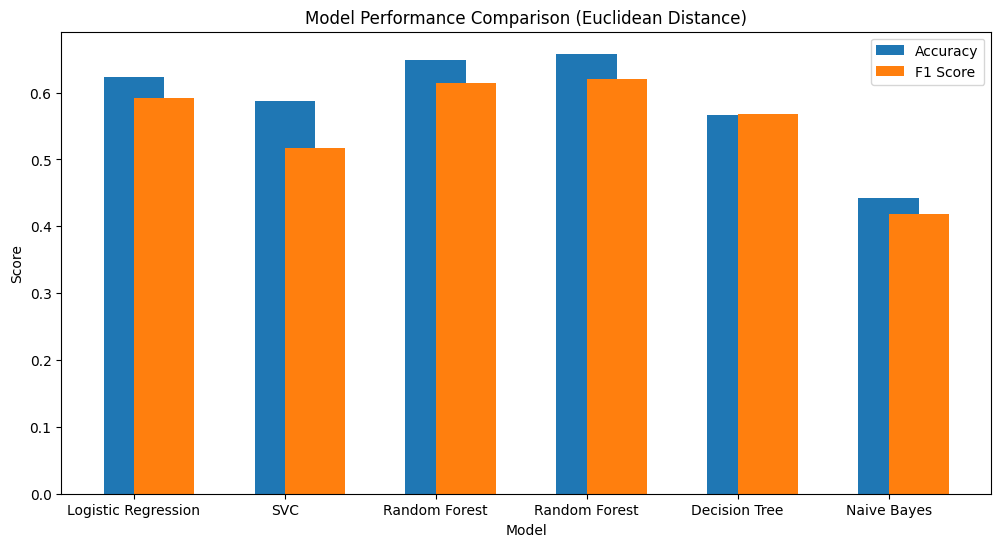

In [40]:
# Plotting results
model_names = [r[0] for r in results_euclidean_bow]
accuracies = [r[1] for r in results_euclidean_bow]
f1_scores = [r[2] for r in results_euclidean_bow]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Euclidean Distance)')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [42]:
df_results_euclidean_bow = pd.DataFrame(results_euclidean_bow, columns=['Model', 'Accuracy', 'F1 Score'])

df_results_euclidean_sorted_bow = df_results_euclidean_bow.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
df_results_euclidean_sorted_bow

,Model,Accuracy,F1 Score
3,Random Forest,0.658058,0.619629
2,Random Forest,0.648760,0.614817
0,Logistic Regression,0.622934,0.591526
1,SVC,0.587810,0.516503
4,Decision Tree,0.567149,0.567594
5,Naive Bayes,0.442149,0.417650


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# TF-IDF

In [43]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Step 1: Smote

In [44]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf, y_train_tfidf = smote.fit_resample(X_train_tfidf, y_train)

In [45]:
# Check shapes
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")
print(f"Shape of y_train_tfidf : {y_train_tfidf.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(Counter(y_train))
Counter(y_train_tfidf)

Shape of X_train_tfidf: (6930, 6402)
Shape of X_test_tfidf: (968, 6402)
Shape of y_train_tfidf : (6930,)
Shape of y_test: (968,)
Counter({0: 2310, 1: 1076, -1: 486})


Counter({-1: 2310, 0: 2310, 1: 2310})

## Step 2: Similarity Score

(a) Cosine Similarity 
(b) Manhattan Similarity
(c) Euclidean Similarity

In [46]:
# Calculate Cosine Similarity Matrix
cosine_sim_train = cosine_similarity(X_train_tfidf)
print("Cosine Similarity Matrix:")
print(cosine_sim_train)

# Calculate Manhattan Distance Matrix
manhattan_dist_train = manhattan_distances(X_train_tfidf)
print("\nManhattan Distance Matrix:")
print(manhattan_dist_train)

# Calculate Euclidean Distance Matrix
euclidean_dist_train = euclidean_distances(X_train_tfidf)
print("\nEuclidean Distance Matrix:")
print(euclidean_dist_train)

Cosine Similarity Matrix:
[[1.         0.         0.         ... 0.         0.02721037 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.01265808 0.04754761]
 [0.02721037 0.         0.         ... 0.01265808 1.         0.        ]
 [0.         0.         0.         ... 0.04754761 0.         1.        ]]

Manhattan Distance Matrix:
[[0.         5.39159462 5.21604463 ... 5.61007535 5.58681814 6.67072042]
 [5.39159462 0.         5.66806736 ... 6.06209808 6.29235129 7.12274315]
 [5.21604463 5.66806736 0.         ... 5.88654809 6.1168013  6.94719316]
 ...
 [5.61007535 6.06209808 5.88654809 ... 0.         6.39547266 6.8968822 ]
 [5.58681814 6.29235129 6.1168013  ... 6.39547266 0.         7.57147709]
 [6.67072042 7.12274315 6.94719316 ... 6.8968822  7.57147709 0.        ]]

Euclidean Distance Matrix:
[[0.         1.41421356 1.4142

In [47]:
cosine_sim_test = cosine_similarity(X_test_tfidf, X_train_tfidf)
manhattan_dist_test = manhattan_distances(X_test_tfidf, X_train_tfidf)
euclidean_dist_test = euclidean_distances(X_test_tfidf, X_train_tfidf)

## Step 3: Modelling

#### (A) WITH COSINE

In [48]:
# Function to train and evaluate classifiers
def train_and_evaluate(clf, cosine_sim_train, y_train, cosine_sim_test, y_test, model_name):
    clf.fit(cosine_sim_train, y_train)
    y_pred = clf.predict(cosine_sim_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [49]:
# List to store results
results_cosine = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "Logistic Regression")
results_cosine.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.7479, F1 Score: 0.7439


In [ ]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "SVC")
results_cosine.append(('SVC', accuracy, f1))

In [ ]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "Random Forest")
results_cosine.append(('Random Forest', accuracy, f1))

In [ ]:
# # Gradient Boosting Classifier
# clf_gb = GradientBoostingClassifier(random_state=42)
# accuracy, f1 = train_and_evaluate(clf_gb, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "Gradient Boosting")
# results_cosine.append(('Gradient Boosting', accuracy, f1))

In [ ]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "Decision Tree")
results_cosine.append(('Decision Tree', accuracy, f1))

In [ ]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, cosine_sim_train, y_train_tfidf, cosine_sim_test, y_test, "Naive Bayes")
results_cosine.append(('Naive Bayes', accuracy, f1))

In [ ]:
# Plotting results
model_names = [r[0] for r in results_cosine]
accuracies = [r[1] for r in results_cosine]
f1_scores = [r[2] for r in results_cosine]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [ ]:
df_results_cosine = pd.DataFrame(results_cosine, columns=['Model', 'Accuracy', 'F1 Score'])

df_results_cosine_sorted = df_results_cosine.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
df_results_cosine_sorted

#### (B) WITH MANHATTAN

In [20]:
def train_and_evaluate(clf, dist_train, y_train, dist_test, y_test, model_name):
    clf.fit(dist_train, y_train)
    y_pred = clf.predict(dist_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [21]:
# List to store results for Manhattan distance
results_manhattan = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "Logistic Regression")
results_manhattan.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.7314, F1 Score: 0.7246


In [26]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "SVC")
results_manhattan.append(('SVC', accuracy, f1))

Model: SVC, Accuracy: 0.7056, F1 Score: 0.6825


In [22]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "Random Forest")
results_manhattan.append(('Random Forest', accuracy, f1))

Model: Random Forest, Accuracy: 0.6756, F1 Score: 0.6644


In [ ]:
# # Gradient Boosting Classifier
# clf_gb = GradientBoostingClassifier(random_state=42)
# accuracy, f1 = train_and_evaluate(clf_gb, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "Gradient Boosting")
# results_manhattan.append(('Gradient Boosting', accuracy, f1))

In [23]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "Decision Tree")
results_manhattan.append(('Decision Tree', accuracy, f1))

Model: Decision Tree, Accuracy: 0.5568, F1 Score: 0.5687


In [24]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, manhattan_dist_train, y_train_tfidf, manhattan_dist_test, y_test, "Naive Bayes")
results_manhattan.append(('Naive Bayes', accuracy, f1))

Model: Naive Bayes, Accuracy: 0.6167, F1 Score: 0.5581


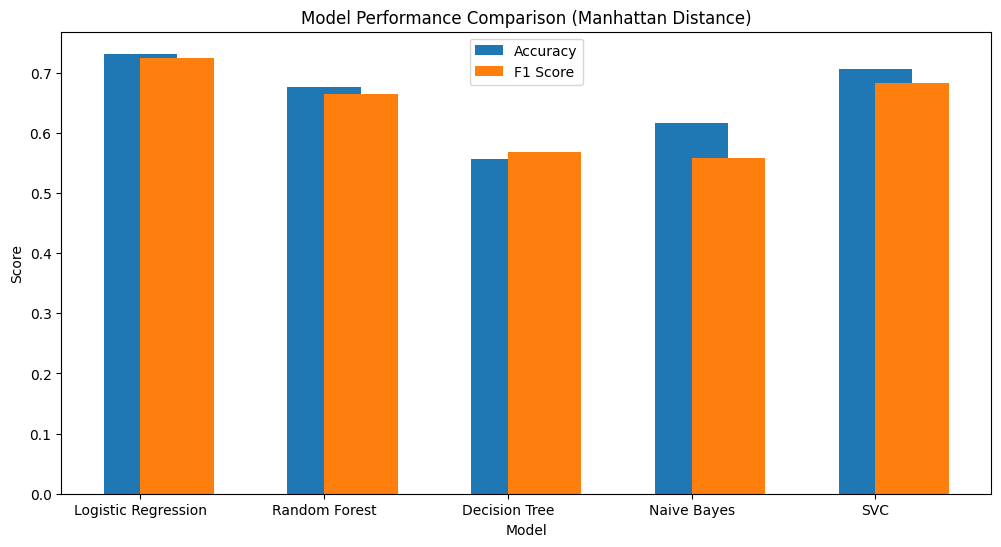

In [28]:
# Plotting results
model_names = [r[0] for r in results_manhattan]
accuracies = [r[1] for r in results_manhattan]
f1_scores = [r[2] for r in results_manhattan]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Manhattan Distance)')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [29]:
# Creating DataFrame for results
df_results_manhattan = pd.DataFrame(results_manhattan, columns=['Model', 'Accuracy', 'F1 Score'])

# Sorting the DataFrame by Accuracy in descending order
df_results_manhattan_sorted = df_results_manhattan.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame
df_results_manhattan_sorted

,Model,Accuracy,F1 Score
0,Logistic Regression,0.731405,0.724604
4,SVC,0.705579,0.682497
1,Random Forest,0.675620,0.664383
3,Naive Bayes,0.616736,0.558136
2,Decision Tree,0.556818,0.568706


#### (B) WITH EUCLIDEAN

In [30]:
# Function to train and evaluate classifiers with Euclidean distance
def train_and_evaluate(clf, dist_train, y_train, dist_test, y_test, model_name):
    clf.fit(dist_train, y_train)
    y_pred = clf.predict(dist_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy, f1

In [31]:
# List to store results for Euclidean distance
results_euclidean = []

# Logistic Regression
clf_lr = LogisticRegression()
accuracy, f1 = train_and_evaluate(clf_lr, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "Logistic Regression")
results_euclidean.append(('Logistic Regression', accuracy, f1))

Model: Logistic Regression, Accuracy: 0.7231, F1 Score: 0.7062


In [ ]:
# SVC
clf_svc = SVC()
accuracy, f1 = train_and_evaluate(clf_svc, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "SVC")
results_euclidean.append(('SVC', accuracy, f1))

In [32]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
accuracy, f1 = train_and_evaluate(clf_rf, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "Random Forest")
results_euclidean.append(('Random Forest', accuracy, f1))

Model: Random Forest, Accuracy: 0.7345, F1 Score: 0.7105


In [ ]:
# # Gradient Boosting Classifier
# clf_gb = GradientBoostingClassifier(random_state=42)
# accuracy, f1 = train_and_evaluate(clf_gb, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "Gradient Boosting")
# results_euclidean.append(('Gradient Boosting', accuracy, f1))

In [34]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier()
accuracy, f1 = train_and_evaluate(clf_dt, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "Decision Tree")
results_euclidean.append(('Decision Tree', accuracy, f1))

Model: Decision Tree, Accuracy: 0.6395, F1 Score: 0.6390


In [35]:
# Naive Bayes Classifier
clf_nb = MultinomialNB()
accuracy, f1 = train_and_evaluate(clf_nb, euclidean_dist_train, y_train_tfidf, euclidean_dist_test, y_test, "Naive Bayes")
results_euclidean.append(('Naive Bayes', accuracy, f1))

Model: Naive Bayes, Accuracy: 0.6095, F1 Score: 0.5412


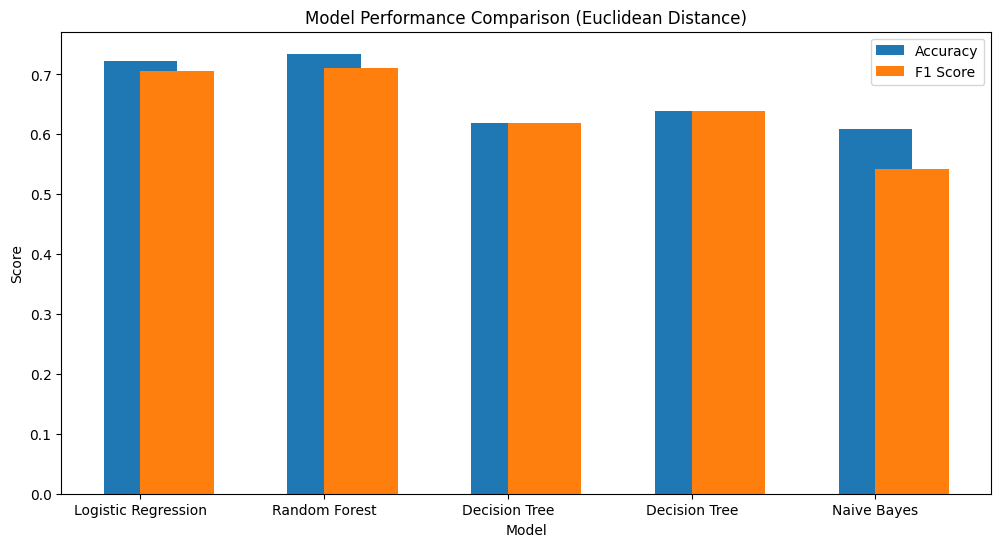

In [36]:
# Plotting results
model_names = [r[0] for r in results_euclidean]
accuracies = [r[1] for r in results_euclidean]
f1_scores = [r[2] for r in results_euclidean]

x = range(len(model_names))

plt.figure(figsize=(12, 6))

plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1_scores, width=0.4, label='F1 Score', align='edge')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison (Euclidean Distance)')
plt.xticks(x, model_names)
plt.legend()
plt.show()

In [37]:
df_results_euclidean = pd.DataFrame(results_euclidean, columns=['Model', 'Accuracy', 'F1 Score'])
df_results_euclidean_sorted = df_results_euclidean.sort_values(by='Accuracy', ascending=False)
df_results_euclidean_sorted

,Model,Accuracy,F1 Score
1,Random Forest,0.734504,0.710490
0,Logistic Regression,0.723140,0.706158
3,Decision Tree,0.639463,0.639036
2,Decision Tree,0.618802,0.619403
4,Naive Bayes,0.609504,0.541247


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~